# Antiderivative Operator - Unaligned Dataset

This tutorial demonstrates the use of learning neural operators for a data driven use case (non-physics informed). 

### References
[1] [Antiderivative operator from an aligned dataset - DeepXDE](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)

[2] [DeepONet Tutorial in JAX](https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/neural_operators/simple_deepOnet_in_JAX.ipynb)

### Install (Colab only)

In [1]:
#%pip install "neuromancer[examples] @ git+https://github.com/pnnl/neuromancer.git@master"
#%pip install watermark

In [2]:
%pwd

'/Users/hamc649/Library/CloudStorage/OneDrive-PNNL/Documents/Neuromancer/repos/neuromancer_deeponet/examples/DeepONets'

In [3]:
# Added this to get working in JetBrains DataSpell, may work without in VSCode
import os

current = os.path.abspath('')
print(current)
repo_name = "neuromancer_deeponet"
while current[-(len(repo_name)):] != repo_name:
    parent = os.path.dirname(current)
    print(parent)
    os.chdir(parent)
    current = parent

/Users/hamc649/Library/CloudStorage/OneDrive-PNNL/Documents/Neuromancer/repos/neuromancer_deeponet/examples/DeepONets
/Users/hamc649/Library/CloudStorage/OneDrive-PNNL/Documents/Neuromancer/repos/neuromancer_deeponet/examples
/Users/hamc649/Library/CloudStorage/OneDrive-PNNL/Documents/Neuromancer/repos/neuromancer_deeponet


### Imports

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from examples.DeepONets.helper import prepare_data, split_test_into_dev_test

# only for development
import sys
sys.path.append('src')

In [5]:
from neuromancer.callbacks import Callback
from neuromancer.constraint import variable
from neuromancer.dataset import DictDataset
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.problem import Problem
from neuromancer.system import Node
from neuromancer.trainer import Trainer

In [6]:
# PyTorch random seed
torch.manual_seed(1234)

# numpy random seed
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Problem Setup

original source: [https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html](https://deepxde.readthedocs.io/en/latest/demos/operator/antiderivative_aligned.html)  

We will learn the antiderivative operator 

$$G : v \mapsto u$$

defined by an ODE

$$\frac{du(x)}{dx} = v(x),\;\;x\in [0,1]$$

**Initial Condition:** 
$$u(0) = (0)$$

We learn *G* from a dataset. Each data point in the dataset is one pair of (v,u), generated as follows:

1. A random function *v* is sampled from a Gaussian random field (GRF) with the resolution m = 100.
2. Solve *u* for *v* numerically. We assume that for each *u*, we have the values of *u(x)* in the same N<sub>u</sub> = 100 locations. Because we have the values of *u(x)* in the same locations, we call this dataset as "aligned data".

* Dataset information
    * The training dataset has size 150.
    * The testing dataset has size 1000. (We split this into a dev/test split of size 500 each)
    * Input of the branch net: the functions *v*. It is a matrix of shape (dataset size, m), e.g., (150, 100) for the training dataset.
    * Input of the trunk net: the locations *x* of *u(x)*. It is a matrix of shape (*N<sub>u</sub>*, dimension)
        * i.e., (100,1) for both training and testing datasets.
    * Output: The values of *u(x)* in different locations for different *v*. It is a matrix of shape (dataset size, *N<sub>u</sub>*).
        * e.g., (150, 100) for the training dataset.



## Dataset Prep

In [7]:
data_dir = "examples/DeepONets/datasets"
Path(data_dir).mkdir(exist_ok=True, parents=True)

### Download Datasets (Colab only)

In [8]:
#!wget https://github.com/pnnl/neuromancer/raw/master/examples/DeepONets/datasets/antiderivative_unaligned_test.npz -nc -O examples/DeepONets/datasets/antiderivative_aligned_test.npz
#!wget https://github.com/pnnl/neuromancer/raw/master/examples/DeepONets/datasets/antiderivative_unaligned_train.npz -nc -O examples/DeepONets/datasets/antiderivative_aligned_train.npz

### Create named dictionary datasets

In [9]:
data_dir = "examples/DeepONets/datasets"

# Load original train/testsplit files
dataset_train = np.load(f"{data_dir}/antiderivative_unaligned_train.npz", allow_pickle=True)
original_test = np.load(f"{data_dir}/antiderivative_unaligned_test.npz", allow_pickle=True)

# Split original test set into 50/50 dev/test splits
dataset_dev, dataset_test = split_test_into_dev_test(original_test)

# Prepare data by transforming shapes
train_data, Nu_train = prepare_data(dataset_train, name="train")
dev_data, Nu_dev = prepare_data(dataset_dev, name="dev")
test_data, Nu_test = prepare_data(dataset_test, name="test")
# GRF resolution, TODO get dynamic
m = 100

train dataset: Nu = 10000, Nsamples = 1
dev dataset: Nu = 50000, Nsamples = 1
test dataset: Nu = 50000, Nsamples = 1


### Create torch DataLoaders for the Trainer

In [10]:
batch_size = 100
print(f"batch_size: {batch_size}")
train_loader = DataLoader(train_data, batch_size=batch_size, collate_fn=train_data.collate_fn, shuffle=False)
dev_loader = DataLoader(dev_data, batch_size=batch_size, collate_fn=dev_data.collate_fn, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, collate_fn=test_data.collate_fn, shuffle=False)

batch_size: 100


## Define node

In [11]:
in_size_branch = m
width_size = 40
depth_branch = 2
interact_size = 40
in_size_trunk = 1
depth_trunk = 2
block_deeponet = blocks.DeepONet(
    insize_branch=in_size_branch,
    insize_trunk=in_size_trunk,
    widthsize=width_size,
    interactsize=interact_size,
    depth_branch=depth_branch,
    depth_trunk=depth_trunk,
    nonlin=activations['relu'],
    bias=True
)

In [12]:
node_deeponet = Node(block_deeponet, ['branch_inputs', 'trunk_inputs'], ['g'], name="deeponet")
print(node_deeponet)

deeponet(branch_inputs, trunk_inputs) -> g


## Objective and Constraints in NeuroMANCER

We use Mean Squared Error(MSE) for our loss function

$$\sum_{i=1}^{D}(x_i-y_i)^2$$



In [13]:
var_y_est = variable("g")
var_y_true = variable("outputs")

nodes = [node_deeponet]

var_loss = (var_y_est == var_y_true.T)^2
var_loss.name = "residual_loss"
objectives = [var_loss]

loss = PenaltyLoss(objectives, constraints=[])

problem = Problem(nodes, loss=loss, grad_inference=True)


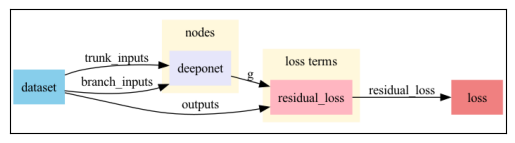

In [14]:
problem.show()

## Problem Solution in NeuroMANCER

In [15]:
lr = 0.001              # step size for gradient descent
epochs = 10000          # number of training epochs
epoch_verbose = 100     # print loss/display loss plot when this many epochs have occurred
warmup = 100            # number of epochs to wait before enacting early stopping policy
patience = 0            # number of epochs with no improvement in eval metric to allow before early stopping

### Construct Trainer and solve the problem

In [16]:
optimizer = torch.optim.AdamW(problem.parameters(), lr=lr)

class LossHistoryCallback(Callback):
    def end_epoch(self, trainer, output):
        if trainer.current_epoch % trainer.epoch_verbose == 0:
            train_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["train"]]
            dev_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["dev"]]
            clear_output(wait=True)
            plt.semilogy(train_loss_history, label="Train loss")
            plt.semilogy(dev_loss_history, label="Dev loss")
            plt.xlabel("# Epochs")
            plt.legend()
            plt.show()

loss_history_callback = LossHistoryCallback()


# define trainer
trainer = Trainer(
    problem.to(device),
    train_data=train_loader,
    dev_data=dev_loader,
    test_data=test_loader,
    optimizer=optimizer,
    logger=None,
    callback=loss_history_callback,
    epochs=epochs,
    patience=patience,
    epoch_verbose=epoch_verbose,
    train_metric='train_loss',
    dev_metric='dev_loss',
    test_metric='test_loss',
    eval_metric="dev_loss",
    warmup = warmup,
    device=device
)

In [17]:
%%time
best_model = trainer.train()

Early stopping!!!
CPU times: user 1min 27s, sys: 3min 49s, total: 5min 17s
Wall time: 44.9 s


In [18]:
# load best trained model
best_outputs = trainer.test(best_model)
problem.load_state_dict(best_model)

<All keys matched successfully>

In [19]:
train_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["train"]]
dev_loss_history = [l.detach().cpu().numpy() for l in trainer.loss_history["dev"]]
mean_test_loss = best_outputs['mean_test_loss'].detach().cpu().numpy()
print(mean_test_loss)
print(f"len(train_loss_history): {len(train_loss_history)}")
print(f"len(dev_loss_history): {len(dev_loss_history)}")

0.10678906
len(train_loss_history): 102
len(dev_loss_history): 102


## Plot loss history w/ mean test loss

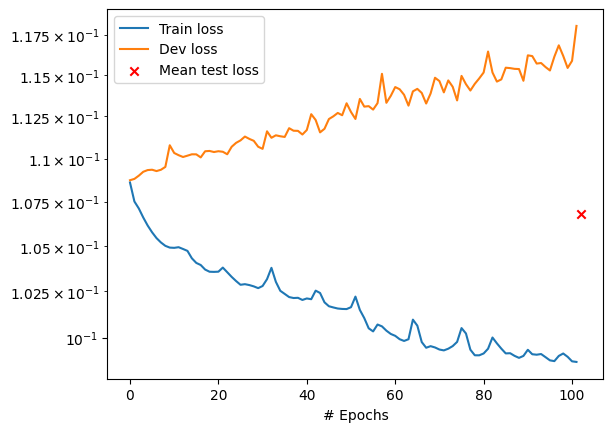

In [20]:
plt.semilogy(train_loss_history, label="Train loss")
plt.semilogy(dev_loss_history, label="Dev loss")
plt.scatter(len(train_loss_history), mean_test_loss, label="Mean test loss", c="red", marker='x')
plt.xlabel("# Epochs")
plt.legend()
plt.show()

## Compare results

In [22]:
k = 18 # k is the k-th function among the 500 test functions
v_ = test_data.datadict["branch_inputs"][:,k]#.reshape(-1,1)
x_ = test_data.datadict["trunk_inputs"]
print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)

res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = test_data.datadict["outputs"][:,k]
u_est = res['g']#.T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='v_')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='u_')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='u_est')

plt.legend()


torch.Size([50000]) torch.Size([50000, 1])


RuntimeError: Tensors must have same number of dimensions: got 1 and 2

## Symbolic Integral Examples

In [ ]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.pow(x_,2).reshape(-1,1)

print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)

res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = (1./3.)*torch.pow(x_,3).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='$v(x) = x^2$')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='integral of v, exact ($x^3/3$)')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='integral of v, estimated')
plt.legend()


In [ ]:
x_ = train_data.datadict["trunk_inputs"]
v_ = torch.cos(x_).reshape(-1,1)

print(v_.shape, x_.shape)

v_ = v_.to(device)
x_ = x_.to(device)

res = problem.predict({'branch_inputs':v_, 'trunk_inputs':x_})

u_ = torch.sin(x_).reshape(-1,1)
u_est = res['g'].T

plt.plot(x_.detach().cpu().numpy(), v_.detach().cpu().numpy(),label='$v(x) = cos(x)$')
plt.plot(x_.detach().cpu().numpy(), u_.detach().cpu().numpy(),label='integral of v, exact ($sin(x)$)')
plt.plot(x_.detach().cpu().numpy(), u_est.detach().cpu().numpy(),label='integral of v, estimated')
plt.legend()

### Watermark

In [ ]:
%load_ext watermark
%watermark
%watermark --iversions